In [1]:
import numpy as np
import pandas as pd
import laspy
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from scipy import ndimage
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Function to read the LIDAR data and convert it into a DataFrame
def read_lidar_to_dataframe(lidar_path):
    with laspy.open(lidar_path) as file:
        laz = file.read()
        lidar_df = pd.DataFrame({
            'x': np.array(laz.x),
            'y': np.array(laz.y),
            'z': np.array(laz.z),
            'intensity':np.array( laz.intensity),
            'return_number': np.array(laz.return_number),
            'number_of_returns':np.array( laz.number_of_returns),
            'scan_angle': np.array(laz.scan_angle),
            'red': np.array(laz.red),
            'green': np.array(laz.green),
            'blue': np.array(laz.blue),
            'nir': np.array(laz.nir),
            'classification': np.array(laz.classification)
        })
    return lidar_df

In [3]:
# Function to read the mask image and create a binary mask
def read_image_to_mask(image_path):
    image = plt.imread(image_path)
    if image.shape[-1] == 4:
        mask = ~np.all(image[:, :, :3] == [0, 0, 0], axis=-1)
    elif image.shape[-1] == 3:
        mask = ~np.all(image == [0, 0, 0], axis=-1)
    else:
        mask = image < 128
    return mask



In [4]:
# Function to project the 3D LiDAR points onto the 2D image plane
def lidar_to_image_pixels(lidar_df, image_shape, mask):
    # width and height of the image
    img_width, img_height = image_shape

    # Calculating the minimum and maximum values of LiDAR data.
    min_x, max_x = lidar_df['x'].min(), lidar_df['x'].max()
    min_y, max_y = lidar_df['y'].min(), lidar_df['y'].max()

    # Scaling x and y coordinates using linear interpolation
    scale_x = (lidar_df['x'] - min_x) / (max_x - min_x)
    scale_y = (lidar_df['y'] - min_y) / (max_y - min_y)

    # Converting the obtained scaled values to pixel coordinates
    lidar_df['image_x'] = np.round(scale_x * (img_width - 1)).astype(int)
    lidar_df['image_y'] = np.round((1 - scale_y) * (img_height - 1)).astype(
        int)  # Y ekseni PNG'de yukarıdan aşağıya doğru artar

    # Checking whether LiDAR points match with a mask or not
    lidar_df['is_tree'] = mask[lidar_df['image_y'], lidar_df['image_x']]

    # Returning a DataFrame containing points representing trees
    return lidar_df[lidar_df['is_tree']]


In [5]:
lidar_path = './SaintLouisLiDAR.laz'
image_path = './SaintLouisTrees.png'

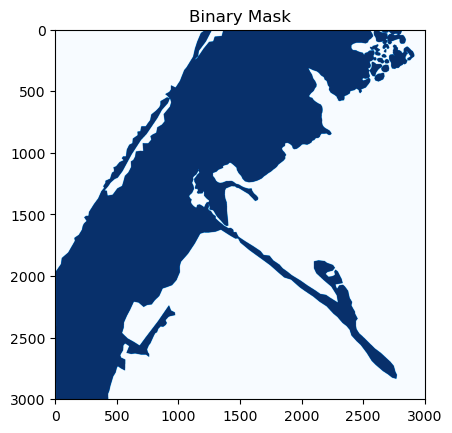

In [6]:
# Read the LiDAR data into a DataFrame
lidar_df = read_lidar_to_dataframe(lidar_path)

# Read the mask image into a binary mask
mask = read_image_to_mask(image_path)

plt.imshow(mask, cmap='Blues')
plt.title('Binary Mask')
plt.show()
image_shape=(3001, 3001)


                  x            y        z  intensity  return_number  \
0        729911.303  4301275.080  160.166      12592              2   
1        729911.981  4301275.055  160.212      12944              3   
2        729912.662  4301275.031  160.258      10848              3   
3        729913.355  4301275.006  160.283       8240              3   
4        729914.036  4301274.981  160.313      15968              1   
...             ...          ...      ...        ...            ...   
9228725  731290.508  4302735.321  202.846       2288              1   
9228726  731290.657  4302736.459  202.865       1904              1   
9228775  731291.180  4302736.707  202.860       2240              1   
9228776  731290.545  4302736.580  202.860       2016              1   
9228777  731290.444  4302737.835  202.824       9216              1   

         number_of_returns  scan_angle    red  green   blue  nir  \
0                        2           0  17664  23296  17920    0   
1          

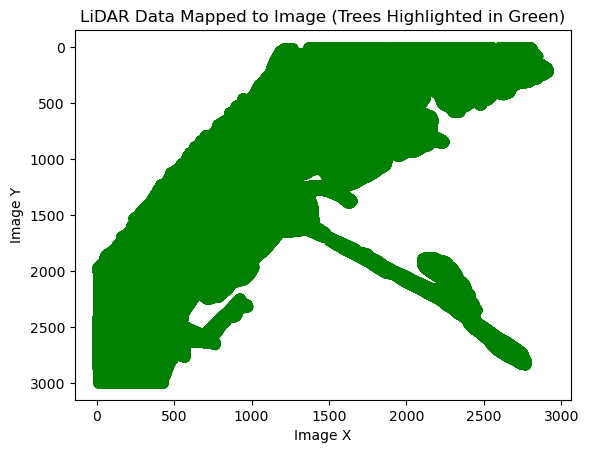

In [7]:
# Apply linear interpolation
lidar_df_mapped = lidar_to_image_pixels(lidar_df, image_shape,mask)

# Project the LiDAR points onto the image plane and filter by the mask
print(lidar_df_mapped)


# Feature selection and classification using tree_points_df
if lidar_df_mapped.empty:
    print("No points were selected. The DataFrame is empty.")
else:
    print("Number of points selected:", len(lidar_df))
    print("First few points:\n", lidar_df.head())

    # Visualize the filtered tree points
    plt.figure(figsize=(6.4, 4.8))
    plt.scatter(lidar_df_mapped[lidar_df_mapped['is_tree']]['image_x'],
                lidar_df_mapped[lidar_df_mapped['is_tree']]['image_y'],
                color='green', label='Trees')
    plt.xlabel('Image X')
    plt.ylabel('Image Y')
    plt.title('LiDAR Data Mapped to Image (Trees Highlighted in Green)')
    plt.gca().invert_yaxis()
    plt.show()


In [8]:
# Defining the features and the target 
features = lidar_df[[ 'intensity', 'return_number', 'number_of_returns',
                     'scan_angle', 'red', 'green', 'blue', 'nir']]
y = lidar_df['is_tree']

# Building an Isolation Forest model and detecting outliers
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(features)

outlier_predictions = iso_forest.fit_predict(features)

# Filtering out the outliers
inliers = lidar_df[outlier_predictions != -1]

In [9]:
# Random Forest
X_inliers = inliers[['intensity', 'return_number', 'number_of_returns',
                     'scan_angle', 'red', 'green', 'blue', 'nir']]
y_inliers = inliers['is_tree']

print(len(inliers), "inliers data")
print(len(lidar_df), "lidar_df data")

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_inliers, y_inliers, test_size=0.3, random_state=42)

""" it takes too long to work

from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', random_state=42)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

"""
""" Model Accuracy: 0.858911045850259
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=5)  

knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)
"""

# Model Accuracy: 0.8628696235618427
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.5, max_depth=3, random_state=42)

gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

7143979 inliers data
9236517 lidar_df data
Model Accuracy: 0.8628696235618427

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.79      0.85   1044097
        True       0.82      0.93      0.87   1099097

    accuracy                           0.86   2143194
   macro avg       0.87      0.86      0.86   2143194
weighted avg       0.87      0.86      0.86   2143194

